In [1]:
import pandas as pd
import numpy as np
import zipcodes as zcode

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


<p>To predict whether a liability customer will buy a personal loan or not
<p>Which variables are most significant
<p>Which segment of customers should be targeted more
<p>Does age have many impact of customer buying loan
<p>Do people with less income borrow loan
<p>......

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', 400)

plt.style.use('ggplot')


<h3>Read and Understand data

In [3]:
df = pd.read_csv('Bank_Personal_Loan_Modelling.csv')
df_loan = df.copy()
print(f'There are {df_loan.shape[0]} rows and {df_loan.shape[1]} columns')

There are 5000 rows and 14 columns


In [4]:
df_loan.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.600,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.500,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.000,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.700,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.000,2,0,0,0,0,0,1


In [5]:
df_loan.tail()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
4995,4996,29,3,40,92697,1,1.900,3,0,0,0,0,1,0
4996,4997,30,4,15,92037,4,0.400,1,85,0,0,0,1,0
4997,4998,63,39,24,93023,2,0.300,3,0,0,0,0,0,0
4998,4999,65,40,49,90034,3,0.500,2,0,0,0,0,1,0
4999,5000,28,4,83,92612,3,0.800,1,0,0,0,0,1,1


In [6]:
df_loan.columns.tolist()

['ID',
 'Age',
 'Experience',
 'Income',
 'ZIP Code',
 'Family',
 'CCAvg',
 'Education',
 'Mortgage',
 'Personal Loan',
 'Securities Account',
 'CD Account',
 'Online',
 'CreditCard']

In [7]:
len(df_loan.columns.tolist())

14

In [8]:
df_loan.isnull().sum().sort_values(ascending=False)

ID                    0
Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64

In [9]:
df_loan.nunique()

ID                    5000
Age                     45
Experience              47
Income                 162
ZIP Code               467
Family                   4
CCAvg                  108
Education                3
Mortgage               347
Personal Loan            2
Securities Account       2
CD Account               2
Online                   2
CreditCard               2
dtype: int64

In [10]:
df_loan.drop(['ID'], axis=1, inplace=True)
df_loan.shape

(5000, 13)

<h3>Data Preprocessing

tên cột có dấu cách gây lỗi khi phân tích

In [11]:
df_loan.rename(columns={'ZIP Code':'ZIPCode', 'Personal Loan':'PersonalLoan', 
                        'Securities Account':'SecuritiesAccount', 'CD Account':'CDAccount'}, inplace=True)

In [12]:
df_loan.ZIPCode.nunique()

467

In [13]:
list_zipcode = df_loan.ZIPCode.unique()

In [14]:
dict_zip = {}
for zipcode in list_zipcode:
    my_city_county = zcode.matching(zipcode.astype('str'))
    if len(my_city_county) == 1:
        county = my_city_county[0].get('county')
    else:
        county = zipcode
    dict_zip.update({zipcode:county})


In [15]:
dict_zip

{91107: 'Los Angeles County',
 90089: 'Los Angeles County',
 94720: 'Alameda County',
 94112: 'San Francisco County',
 91330: 'Los Angeles County',
 92121: 'San Diego County',
 91711: 'Los Angeles County',
 93943: 'Monterey County',
 93023: 'Ventura County',
 94710: 'Alameda County',
 90277: 'Los Angeles County',
 93106: 'Santa Barbara County',
 94920: 'Marin County',
 91741: 'Los Angeles County',
 95054: 'Santa Clara County',
 95010: 'Santa Cruz County',
 94305: 'Santa Clara County',
 91604: 'Los Angeles County',
 94015: 'San Mateo County',
 90095: 'Los Angeles County',
 91320: 'Ventura County',
 95521: 'Humboldt County',
 95064: 'Santa Cruz County',
 90064: 'Los Angeles County',
 94539: 'Alameda County',
 94104: 'San Francisco County',
 94117: 'San Francisco County',
 94801: 'Contra Costa County',
 94035: 'Santa Clara County',
 92647: 'Orange County',
 95814: 'Sacramento County',
 94114: 'San Francisco County',
 94115: 'San Francisco County',
 92672: 'Orange County',
 94122: 'San Fra

In [16]:
dict_zip.update({92717: 'Orange County'})
dict_zip.update({92634: 'Orange County'})

In [17]:
df_loan['County'] = df_loan['ZIPCode'].map(dict_zip)

In [18]:
df_loan.County.nunique()

40

In [19]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                5000 non-null   int64  
 1   Experience         5000 non-null   int64  
 2   Income             5000 non-null   int64  
 3   ZIPCode            5000 non-null   int64  
 4   Family             5000 non-null   int64  
 5   CCAvg              5000 non-null   float64
 6   Education          5000 non-null   int64  
 7   Mortgage           5000 non-null   int64  
 8   PersonalLoan       5000 non-null   int64  
 9   SecuritiesAccount  5000 non-null   int64  
 10  CDAccount          5000 non-null   int64  
 11  Online             5000 non-null   int64  
 12  CreditCard         5000 non-null   int64  
 13  County             5000 non-null   object 
dtypes: float64(1), int64(12), object(1)
memory usage: 547.0+ KB


In [20]:
category_col = ['PersonalLoan', 'SecuritiesAccount', 'Family', 'CDAccount', 'Online', 'CreditCard',
                        'ZIPCode', 'Education', 'County']

df_loan[category_col] = df_loan[category_col].astype('category')

In [21]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Age                5000 non-null   int64   
 1   Experience         5000 non-null   int64   
 2   Income             5000 non-null   int64   
 3   ZIPCode            5000 non-null   category
 4   Family             5000 non-null   category
 5   CCAvg              5000 non-null   float64 
 6   Education          5000 non-null   category
 7   Mortgage           5000 non-null   int64   
 8   PersonalLoan       5000 non-null   category
 9   SecuritiesAccount  5000 non-null   category
 10  CDAccount          5000 non-null   category
 11  Online             5000 non-null   category
 12  CreditCard         5000 non-null   category
 13  County             5000 non-null   category
dtypes: category(9), float64(1), int64(4)
memory usage: 266.4 KB


In [22]:
df_loan[df_loan['Experience'] < 0]['Age'].describe()

count   52.000
mean    24.519
std      1.475
min     23.000
25%     24.000
50%     24.000
75%     25.000
max     29.000
Name: Age, dtype: float64

In [23]:
df_loan[df_loan['Experience'] < 0].sort_values(by='Experience', ascending=True)

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,PersonalLoan,SecuritiesAccount,CDAccount,Online,CreditCard,County
4514,24,-3,41,91768,4,1.000,3,0,0,0,0,1,0,Los Angeles County
2618,23,-3,55,92704,3,2.400,2,145,0,0,0,1,0,Orange County
4285,23,-3,149,93555,2,7.200,1,0,0,0,0,1,0,Kern County
3626,24,-3,28,90089,4,1.000,3,0,0,0,0,0,0,Los Angeles County
2717,23,-2,45,95422,4,0.600,2,0,0,0,0,1,1,Lake County
2876,24,-2,80,91107,2,1.600,3,238,0,0,0,0,0,Los Angeles County
3130,23,-2,82,92152,2,1.800,2,0,0,1,0,0,1,San Diego County
2466,24,-2,80,94105,2,1.600,3,0,0,0,0,1,0,San Francisco County
3796,24,-2,50,94920,3,2.400,2,0,0,1,0,0,0,Marin County
2962,23,-2,81,91711,2,1.800,2,0,0,0,0,0,0,Los Angeles County


In [24]:
df_loan.groupby(['Age', 'Education'])['Experience'].describe().T

Age           23            24                   25                   26  \
Education      1      2      1      2      3      1      2      3      1   
count      7.000  5.000 13.000  8.000  7.000 23.000 11.000 19.000 30.000   
mean      -1.286 -2.200 -0.692 -0.875 -2.000  0.522 -0.273 -0.526  1.433   
std        0.756  0.447  0.947  0.641  1.000  0.790  0.647  0.697  0.817   
min       -3.000 -3.000 -2.000 -2.000 -3.000 -1.000 -1.000 -2.000  0.000   
25%       -1.000 -2.000 -2.000 -1.000 -2.500  0.000 -1.000 -1.000  1.000   
50%       -1.000 -2.000  0.000 -1.000 -2.000  1.000  0.000 -1.000  2.000   
75%       -1.000 -2.000  0.000 -0.750 -2.000  1.000  0.000  0.000  2.000   
max       -1.000 -2.000  0.000  0.000  0.000  1.000  1.000  1.000  2.000   

Age               ...     64     65                   66                   67  \
Education      2  ...      3      1      2      3      1      2      3      1   
count     24.000  ... 30.000 30.000 23.000 27.000  9.000  5.000 10.000  5.000   
mean       0.750  ... 38.533 39.867 40.087 39.519 41.111 41.400 40.400 41.600   
std        0.847  ...  1.756  0.730  0.733  1.553  0.333  0.548  1.647  0.894   
min       -1.000  ... 34.000 39.000 39.000 35.000 41.000 41.000 36.000 41.000   
25%        0.000  ... 38.000 39.000 40.000 39.000 41.000 41.000 40.250 41.000   
50%        1.000  ... 39.000 40.000 40.000 40.000 41.000 41.000 41.000 41.000   
75%        1.000  ... 40.000 40.000 41.000 41.000 41.000 42.000 41.000 42.000   
max        2.000  ... 40.000 41.000 41.000 41.000 42.000 42.000 42.000 43.000   

Age                      
Education      2      3  
count      3.000  4.000  
mean      42.667 41.500  
std        0.577  0.577  
min       42.000 41.000  
25%       42.500 41.000  
50%       43.000 41.500  
75%       43.000 42.000  
max       43.000 42.000  

[8 rows x 134 columns]

In [25]:
df_loan.loc[df_loan['Experience'] < 0, 'Experience'] = np.abs(df_loan['Experience'])

In [26]:
df_loan.groupby(['Age', 'Education'])['Experience'].describe().T

Age          23           24                 25                   26         \
Education     1     2      1     2     3      1      2      3      1      2   
count     7.000 5.000 13.000 8.000 7.000 23.000 11.000 19.000 30.000 24.000   
mean      1.286 2.200  0.692 0.875 2.000  0.870  0.455  0.632  1.433  0.833   
std       0.756 0.447  0.947 0.641 1.000  0.344  0.522  0.597  0.817  0.761   
min       1.000 2.000  0.000 0.000 0.000  0.000  0.000  0.000  0.000  0.000   
25%       1.000 2.000  0.000 0.750 2.000  1.000  0.000  0.000  1.000  0.000   
50%       1.000 2.000  0.000 1.000 2.000  1.000  0.000  1.000  2.000  1.000   
75%       1.000 2.000  2.000 1.000 2.500  1.000  1.000  1.000  2.000  1.000   
max       3.000 3.000  2.000 2.000 3.000  1.000  1.000  2.000  2.000  2.000   

Age        ...     64     65                   66                   67         \
Education  ...      3      1      2      3      1      2      3      1      2   
count      ... 30.000 30.000 23.000 27.000  9.000  5.000 10.000  5.000  3.000   
mean       ... 38.533 39.867 40.087 39.519 41.111 41.400 40.400 41.600 42.667   
std        ...  1.756  0.730  0.733  1.553  0.333  0.548  1.647  0.894  0.577   
min        ... 34.000 39.000 39.000 35.000 41.000 41.000 36.000 41.000 42.000   
25%        ... 38.000 39.000 40.000 39.000 41.000 41.000 40.250 41.000 42.500   
50%        ... 39.000 40.000 40.000 40.000 41.000 41.000 41.000 41.000 43.000   
75%        ... 40.000 40.000 41.000 41.000 41.000 42.000 41.000 42.000 43.000   
max        ... 40.000 41.000 41.000 41.000 42.000 42.000 42.000 43.000 43.000   

Age               
Education      3  
count      4.000  
mean      41.500  
std        0.577  
min       41.000  
25%       41.000  
50%       41.500  
75%       42.000  
max       42.000  

[8 rows x 134 columns]

In [27]:
df_loan[df_loan['Experience'] == 0]['Age'].describe()

count   66.000
mean    25.636
std      1.145
min     24.000
25%     25.000
50%     26.000
75%     26.000
max     30.000
Name: Age, dtype: float64

In [28]:
df_loan.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,5000.000,45.338,11.463,23.000,35.000,45.000,55.000,67.000
Experience,5000.000,20.135,11.415,0.000,10.000,20.000,30.000,43.000
Income,5000.000,73.774,46.034,8.000,39.000,64.000,98.000,224.000
CCAvg,5000.000,1.938,1.748,0.000,0.700,1.500,2.500,10.000
Mortgage,5000.000,56.499,101.714,0.000,0.000,0.000,101.000,635.000


In [29]:
for column in category_col:
    print(df_loan[column].value_counts())
    print('#' * 40) 

0    4520
1     480
Name: PersonalLoan, dtype: int64
########################################
0    4478
1     522
Name: SecuritiesAccount, dtype: int64
########################################
1    1472
2    1296
4    1222
3    1010
Name: Family, dtype: int64
########################################
0    4698
1     302
Name: CDAccount, dtype: int64
########################################
1    2984
0    2016
Name: Online, dtype: int64
########################################
0    3530
1    1470
Name: CreditCard, dtype: int64
########################################
94720    169
94305    127
95616    116
90095     71
93106     57
        ... 
94087      1
90813      1
94404      1
90068      1
9307       1
Name: ZIPCode, Length: 467, dtype: int64
########################################
1    2096
3    1501
2    1403
Name: Education, dtype: int64
########################################
Los Angeles County        1095
San Diego County           568
Santa Clara County         563
Alameda C

In [30]:
def dist_plot(data):
    Name = data.name.upper()
    fig, (ax_box, ax_dist) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': (0.25, 0.75)},
        figsize=(8,5))
    mean = data.mean()
    median = data.median()
    mode = data.mode().tolist()[0]
    sns.set_theme(style='white')
    fig.suptitle("SPREAD OD DATA FOR "+ Name, fontsize=18, fontweight='bold')
    sns.boxplot(x=data, showmeans=True, orient='h', color='violet', ax=ax_box)
    ax_box.set(xlabel='')
    sns.despine(top=True, right=True, left=True)
    sns.distplot(data, kde=False, color='blue', ax=ax_dist)
    ax_dist.axvline(mean, color='r', linestyle='--', linewidth=2)
    ax_dist.axvline(median, color='g', linestyle='--', linewidth=2)
    ax_dist.axvline(mode, color='y', linestyle='--', linewidth=2)
    plt.legend({'Mean': mean, 'Median': median, 'Mode':mode})



C:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displ

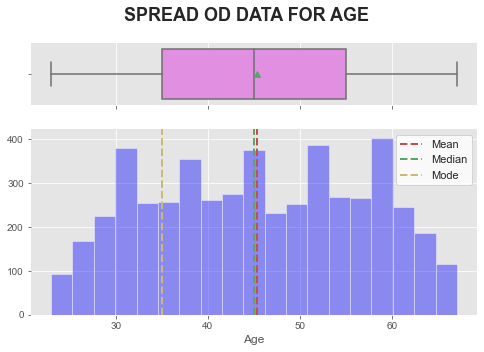

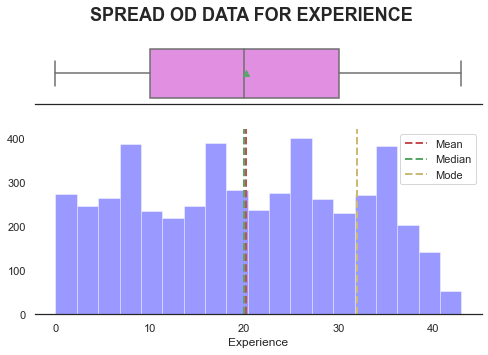

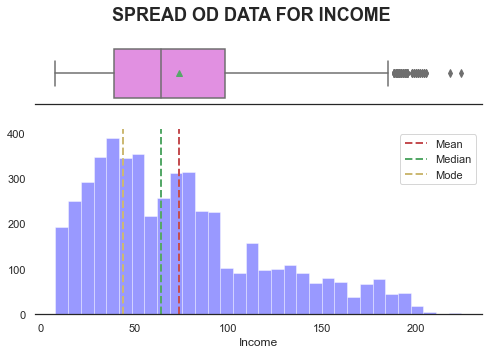

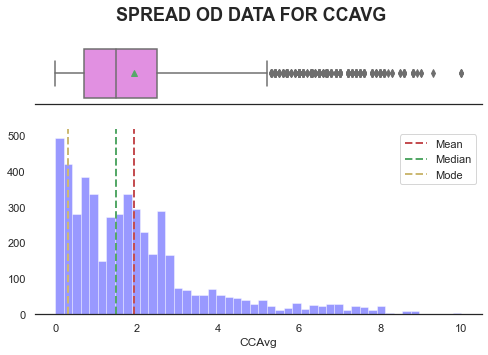

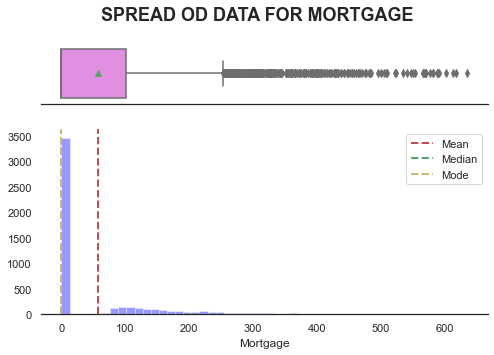

In [31]:
list_col = ['Age', 'Experience', 'Income', 'CCAvg','Mortgage']
for i in range(len(list_col)):
    dist_plot(df_loan[list_col[i]])

<h3>Age 

In [32]:
df_loan['AgeBin'] = pd.cut(df_loan['Age'], 
                            bins=[0, 30, 40, 50, 60, 100], 
                            labels=['18-30','31-40','41-50','51-60','61-100'])
df_loan['AgeBin']

0        18-30
1        41-50
2        31-40
3        31-40
4        31-40
         ...  
4995     18-30
4996     18-30
4997    61-100
4998    61-100
4999     18-30
Name: AgeBin, Length: 5000, dtype: category
Categories (5, object): ['18-30' < '31-40' < '41-50' < '51-60' < '61-100']

<h3>Income

In [33]:
df_loan['Income_group']= pd.cut(
    x = df_loan['Income'],
    bins = [0,50,140,224],
    labels=['Lower','Middle','High']
)
df_loan['Income_group']

0        Lower
1        Lower
2        Lower
3       Middle
4        Lower
         ...  
4995     Lower
4996     Lower
4997     Lower
4998     Lower
4999    Middle
Name: Income_group, Length: 5000, dtype: category
Categories (3, object): ['Lower' < 'Middle' < 'High']

<h3>Spending CC

In [34]:
df_loan.CCAvg.describe()

count   5000.000
mean       1.938
std        1.748
min        0.000
25%        0.700
50%        1.500
75%        2.500
max       10.000
Name: CCAvg, dtype: float64

In [35]:
df_loan['Spending_group'] = pd.cut(df_loan['CCAvg'], bins=[0.00000,0.70000,2.50000, 10.00000],
                labels=['Low','Medium','High'], include_lowest=True)

df_loan['Spending_group']

0       Medium
1       Medium
2       Medium
3         High
4       Medium
         ...  
4995    Medium
4996       Low
4997       Low
4998       Low
4999    Medium
Name: Spending_group, Length: 5000, dtype: category
Categories (3, object): ['Low' < 'Medium' < 'High']

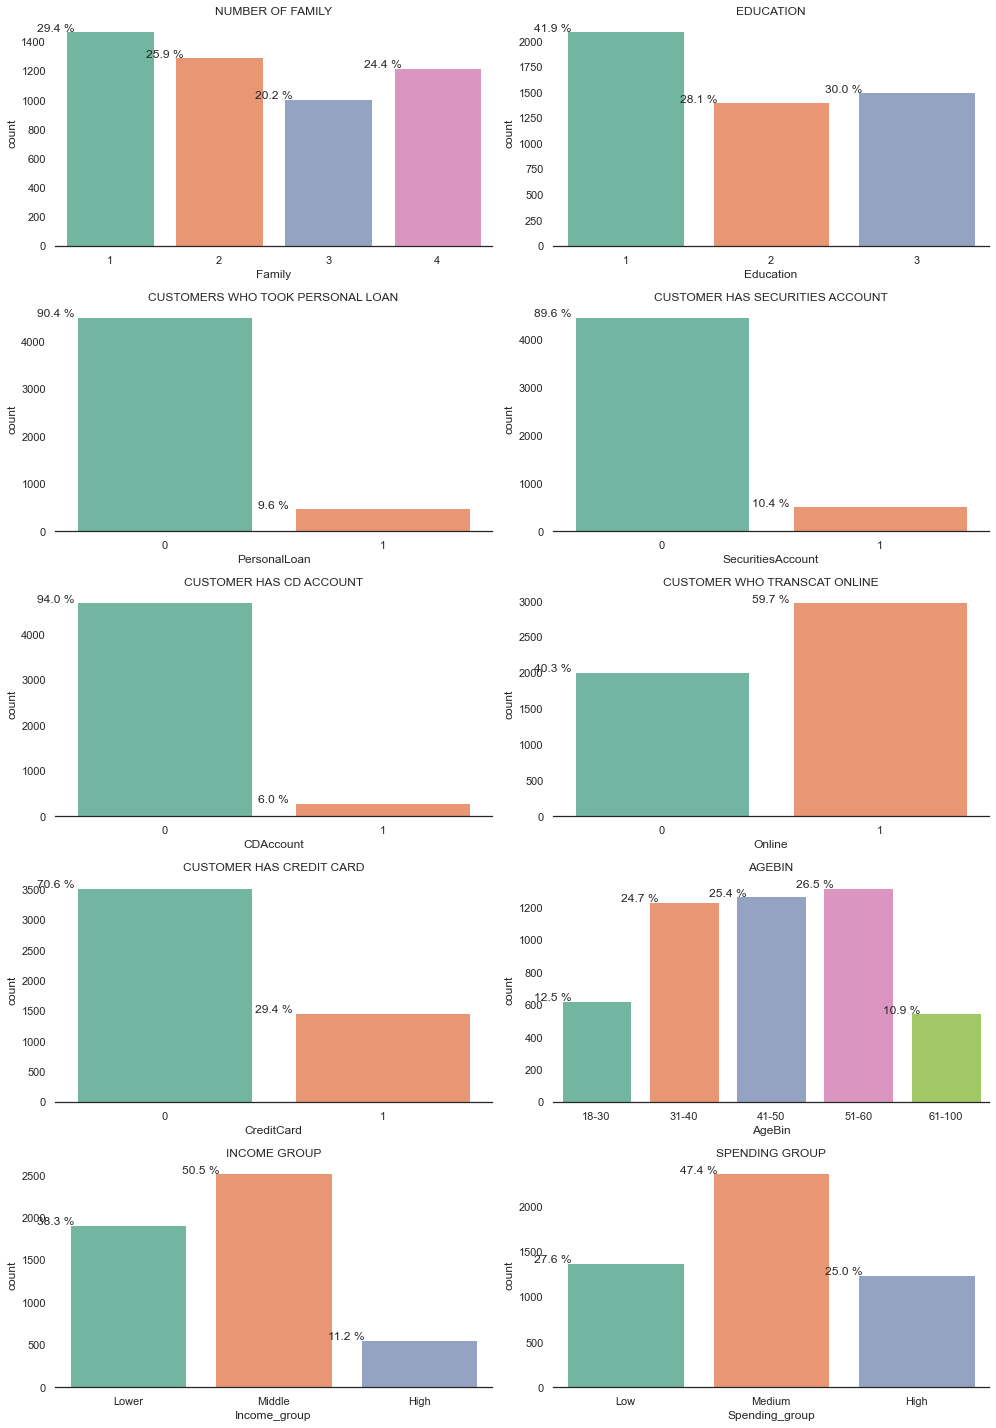

In [36]:
cat_columns = ['Family','Education','PersonalLoan','SecuritiesAccount',
                'CDAccount','Online','CreditCard','AgeBin','Income_group','Spending_group']
title = ['Number of Family', 'Education', 'Customers who took personal loan','Customer has securities account',
        'Customer has CD account','Customer who transcat online', 'Customer has credit card', 'AgeBin', 'Income group', 'Spending group']
plt.figure(figsize=(14,20))
sns.set_theme(style='white')
for i, variable in enumerate(cat_columns):
    plt.subplot(5,2,i+1)
    order = df_loan[variable].value_counts(ascending=False).index
    sns.set_palette('Set2')
    ax = sns.countplot(x=df_loan[variable], data=df_loan)
    sns.despine(top=True, right=True, left=True)
    for p in ax.patches:
        percentage = '{:.1f} %'.format(100 * p.get_height() / len(df_loan[variable]))
        x = p.get_x() + p.get_width() / 2 - 0.5
        y= p.get_y() + p.get_height()
        plt.annotate(percentage, (x,y), ha='center')
    plt.tight_layout()
    plt.title(title[i].upper())


In [37]:
df_loan.groupby(['County', 'PersonalLoan'])['PersonalLoan'].agg({'size'}).unstack()

size     
PersonalLoan              0    1
County                          
9307                      1    0
96651                     6    0
Alameda County          456   44
Butte County             17    2
Contra Costa County      73   12
El Dorado County         16    1
Fresno County            24    2
Humboldt County          30    2
Imperial County           3    0
Kern County              47    7
Lake County               4    0
Los Angeles County      984  111
Marin County             48    6
Mendocino County          7    1
Merced County             4    0
Monterey County         113   15
Napa County               3    0
Orange County           333   33
Placer County            22    2
Riverside County         50    6
Sacramento County       169   15
San Benito County        14    0
San Bernardino County    98    3
San Diego County        509   59
San Francisco County    238   19
San Joaquin County       12    1
San Luis Obispo County   28    5
San Mateo County        192   12
Santa Barbara County    143   11
Santa Clara County      492   71
Santa Cruz County        60    8
Shasta County            15    3
Siskiyou County           7    0
Solano County            30    3
Sonoma County            22    6
Stanislaus County        14    1
Trinity County            4    0
Tuolumne County           7    0
Ventura County          103   11
Yolo County             122    8

<AxesSubplot:ylabel='County'>

<Figure size 1080x1728 with 0 Axes>

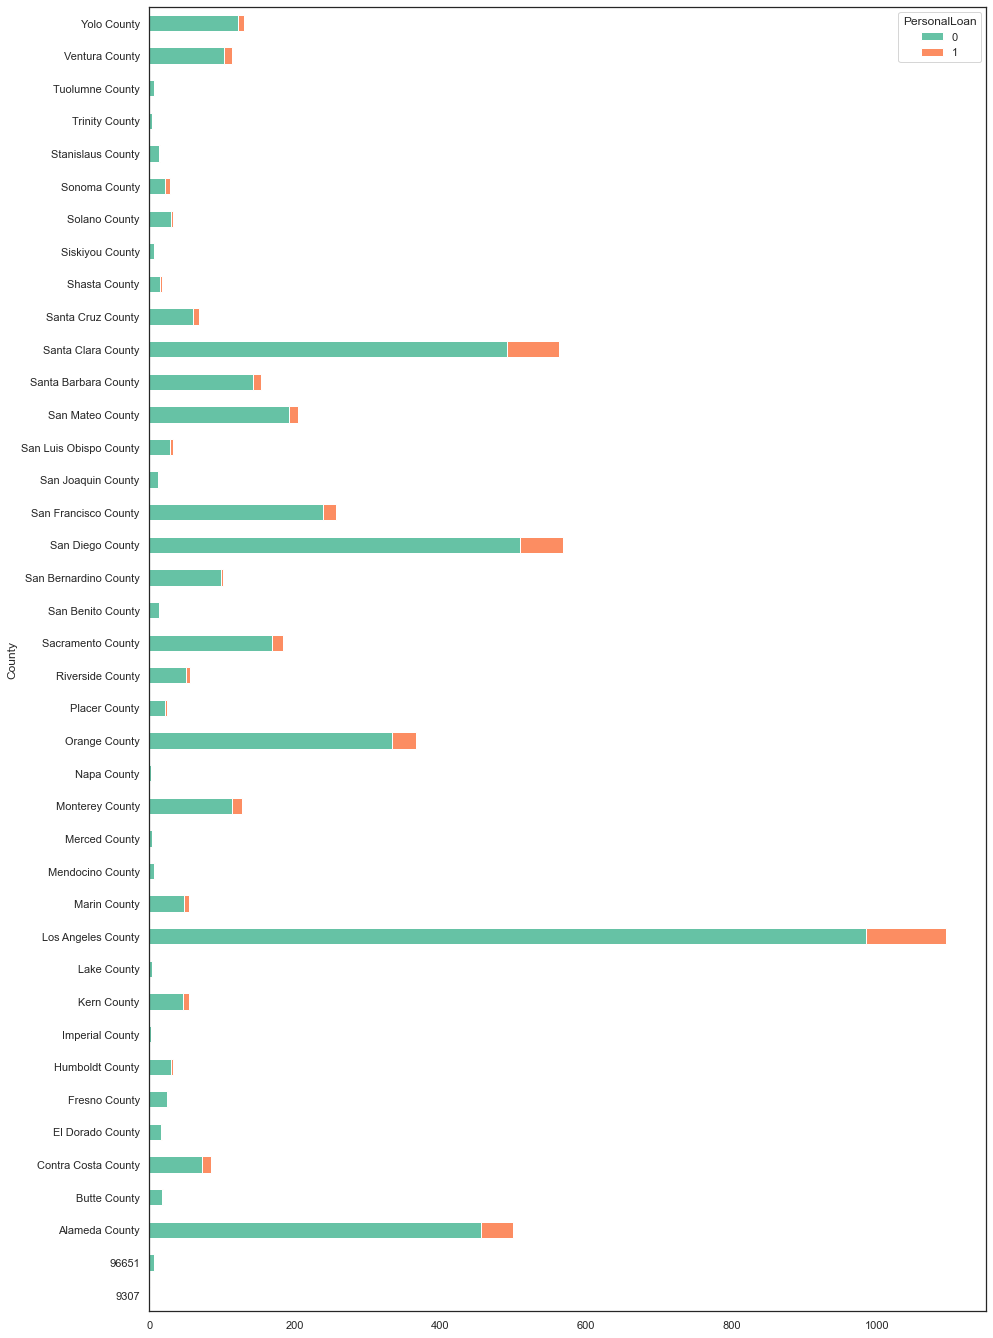

In [38]:
plt.figure(figsize=(15,24))
pd.crosstab(index=df_loan['County'], columns=df_loan['PersonalLoan'].sort_values(ascending=False)).plot(
    kind='barh', stacked=True, figsize=(15,24)
)

In [39]:
counties = {
'Los Angeles County':'Los Angeles Region',
'San Diego County':'Southern',
'Santa Clara County':'Bay Area',
'Alameda County':'Bay Area',
'Orange County':'Southern',
'San Francisco County':'Bay Area',
'San Mateo County':'Bay Area',
'Sacramento County':'Central',
'Santa Barbara County':'Southern',
'Yolo County':'Central',
'Monterey County':'Bay Area',            
'Ventura County':'Southern',             
'San Bernardino County':'Southern',       
'Contra Costa County':'Bay Area',        
'Santa Cruz County':'Bay Area',           
'Riverside County':'Southern',            
'Kern County':'Southern',                 
'Marin County':'Bay Area',                
'San Luis Obispo County':'Southern',     
'Solano County':'Bay Area',              
'Humboldt County':'Superior',            
'Sonoma County':'Bay Area', 
'Fresno County':'Central',               
'Placer County':'Central',                
'Butte County':'Superior',               
'Shasta County':'Superior',                
'El Dorado County':'Central',             
'Stanislaus County':'Central',            
'San Benito County':'Bay Area',          
'San Joaquin County':'Central',           
'Mendocino County':'Superior',             
'Tuolumne County':'Central',                
'Siskiyou County':'Superior',              
'Trinity County':'Superior',                
'Merced County':'Central',                  
'Lake County':'Superior',                 
'Napa County':'Bay Area',                   
'Imperial County':'Southern',
93077:'Southern',
96651:'Bay Area'
}

In [40]:
df_loan['Regions'] = df_loan['County'].map(counties)

In [41]:
df_loan['Regions'].nunique()

5

In [42]:
df_loan.isnull().sum()

Age                  0
Experience           0
Income               0
ZIPCode              0
Family               0
CCAvg                0
Education            0
Mortgage             0
PersonalLoan         0
SecuritiesAccount    0
CDAccount            0
Online               0
CreditCard           0
County               0
AgeBin               0
Income_group         0
Spending_group       0
Regions              1
dtype: int64

In [43]:
df_loan.dropna(inplace=True)

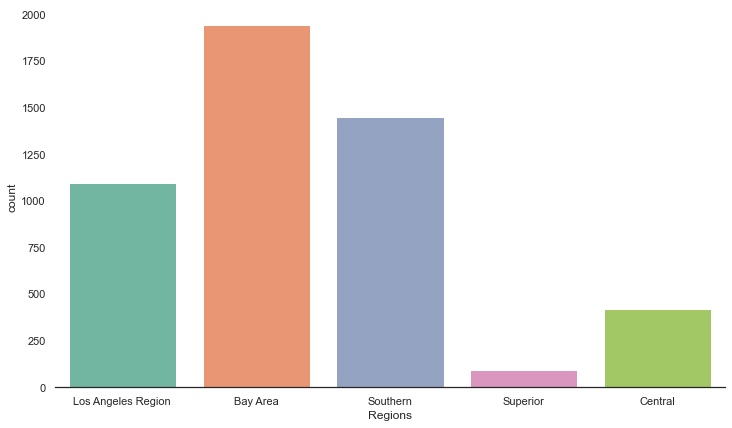

In [44]:
plt.figure(figsize=(12,7))
sns.countplot(data=df_loan, x=df_loan['Regions'])
sns.despine(top=True, right=True, left=True)


In [45]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4999 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Age                4999 non-null   int64   
 1   Experience         4999 non-null   int64   
 2   Income             4999 non-null   int64   
 3   ZIPCode            4999 non-null   category
 4   Family             4999 non-null   category
 5   CCAvg              4999 non-null   float64 
 6   Education          4999 non-null   category
 7   Mortgage           4999 non-null   int64   
 8   PersonalLoan       4999 non-null   category
 9   SecuritiesAccount  4999 non-null   category
 10  CDAccount          4999 non-null   category
 11  Online             4999 non-null   category
 12  CreditCard         4999 non-null   category
 13  County             4999 non-null   category
 14  AgeBin             4999 non-null   category
 15  Income_group       4999 non-null   category
 16  Spendi

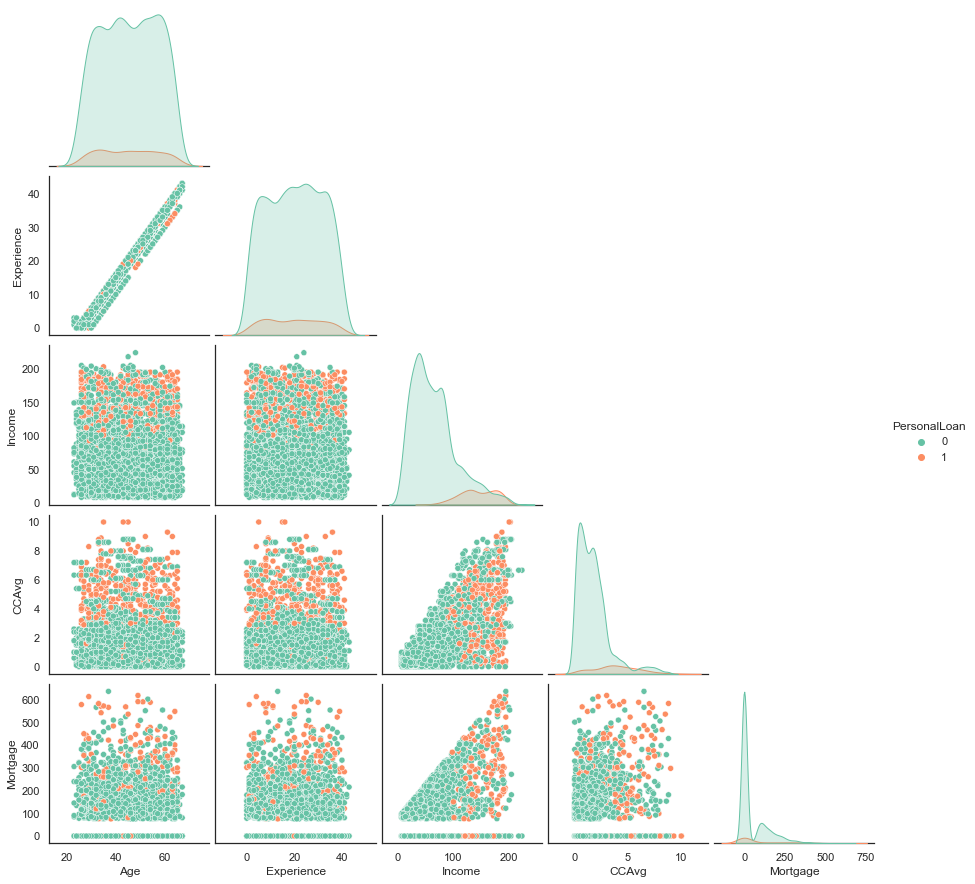

In [46]:
sns.set_palette(sns.color_palette("Set2", 8))
sns.pairplot(df_loan, hue='PersonalLoan', corner=True)
plt.show()

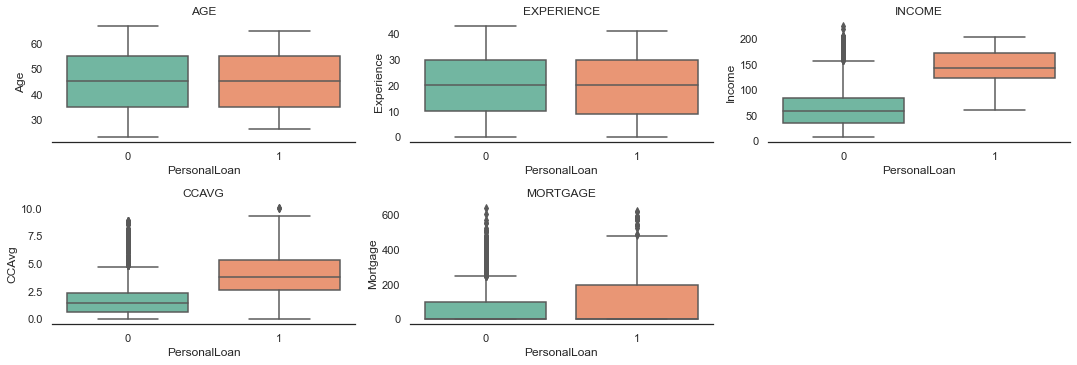

In [47]:
numeric_columns = ['Age','Experience', 'Income','CCAvg', 'Mortgage']
plt.figure(figsize=(15,25))

sns.set_palette(sns.color_palette('Set2',8))
for i, variable in enumerate(numeric_columns):
    plt.subplot(10,3, i+1)
    sns.boxplot(x='PersonalLoan', y=df_loan[variable], data=df_loan)
    sns.despine(top=True, right=True, left=True)
    plt.tight_layout()
    plt.title(variable.upper())

In [48]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4999 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Age                4999 non-null   int64   
 1   Experience         4999 non-null   int64   
 2   Income             4999 non-null   int64   
 3   ZIPCode            4999 non-null   category
 4   Family             4999 non-null   category
 5   CCAvg              4999 non-null   float64 
 6   Education          4999 non-null   category
 7   Mortgage           4999 non-null   int64   
 8   PersonalLoan       4999 non-null   category
 9   SecuritiesAccount  4999 non-null   category
 10  CDAccount          4999 non-null   category
 11  Online             4999 non-null   category
 12  CreditCard         4999 non-null   category
 13  County             4999 non-null   category
 14  AgeBin             4999 non-null   category
 15  Income_group       4999 non-null   category
 16  Spendi

In [49]:
df_loan.drop(columns=['AgeBin','ZIPCode','Experience','Income_group','Spending_group','County'], inplace=True)

In [50]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4999 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Age                4999 non-null   int64   
 1   Income             4999 non-null   int64   
 2   Family             4999 non-null   category
 3   CCAvg              4999 non-null   float64 
 4   Education          4999 non-null   category
 5   Mortgage           4999 non-null   int64   
 6   PersonalLoan       4999 non-null   category
 7   SecuritiesAccount  4999 non-null   category
 8   CDAccount          4999 non-null   category
 9   Online             4999 non-null   category
 10  CreditCard         4999 non-null   category
 11  Regions            4999 non-null   object  
dtypes: category(7), float64(1), int64(3), object(1)
memory usage: 398.5+ KB


In [51]:
X = df_loan.drop(['PersonalLoan'], axis=1)
Y = df_loan['PersonalLoan']

oneHotCols = ['Regions','Education']
X = pd.get_dummies(X, columns=oneHotCols, drop_first=True)

In [52]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=Y)

In [53]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

x_scaler = scaler.fit(X_train)

X_train_scaled = x_scaler.transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

Y_train.index = np.arange(len(Y_train))
Y_test.index = np.arange(len(Y_test))

<h3>Model building Logistic Regression

<p>Model can make wrong prediction as:
<ol>
<li>Predicting a person will buy a loan => he actually doesn't (loss of resource)
<li>Predicting a person wont buy a loan => he actually (loss of opportunity)

In [54]:
def get_metric_score(model, x_train_df, X_test, Y_train, Y_test, statsklearn,
    threshold = 0.5, flag=True, roc=False):
    score_list=[]
    if statmodel == 0:
        pred_train = model.predict(x_train_df)
        pred_test = model.predict(X_test)
    else:
        pred_train = (model.predict(x_train_df) > threshold)
        pred_test = (model.predict(X_test) > threshold)
    
    pred_train = np.round(pred_train)
    pred_test = np.round(pred_test)

    train_acc = accuracy_score(Y_train, pred_train)
    test_acc = accuracy_score(Y_test, pred_test)

    train_recall = recall_score(Y_train, pred_train)
    test_recall = recall_score(Y_test, pred_test)

    train_precision = precision_score(Y_train, pred_train)
    test_precision = precision_score(Y_test, pred_test)

    train_f1 = f1_score(Y_train, pred_train)
    test_f1 = f1_score(Y_test, pred_test)

    if flag == True:
        print('Model performance: ')
        print("Accuracy: Train", round(train_acc, 3), "Test", round(test_acc, 3))
        print("Recall: Train", round(train_recall, 3), "Test", round(test_recall, 3))
        print("Precision: Train", round(train_precision, 3), "Test", round(test_precision, 3))
        print("F1: Train", round(train_f1, 3), "Test", round(test_f1, 3))

    if roc == True:
        print("ROC score: Train ", round(roc_auc_score(Y_train, pred_train), 3), 
            "Test", round(roc_auc_score(Y_test, pred_test), 3)) 

    score_list.extend((train_acc, test_acc, train_recall,
                        test_recall, train_precision, test_precision, train_f1, test_f1))
    return score_list

In [55]:
lr = LogisticRegression(solver='newton-cg', random_state=1, fit_intercept=False, class_weight={0:0.2, 1:0.85})
model = lr.fit(X_train_scaled_df, Y_train)

statmodel = 0 

scores_sklearn = get_metric_score(model, X_train_scaled_df, X_test_scaled_df, Y_train, Y_test, statmodel)
# pred_y = model.predict(X)

Model performance: 
Accuracy: Train 0.652 Test 0.667
Recall: Train 0.982 Test 0.99
Precision: Train 0.214 Test 0.222
F1: Train 0.351 Test 0.363


In [56]:
X_train_stat = sm.add_constant(X_train_scaled_df)
X_test_stat = sm.add_constant(X_test_scaled_df)

statmodel = 1

logit = sm.Logit(Y_train, X_train_stat.astype(float))
lg = logit.fit(warn_convergence = False)

score_statmodel = get_metric_score(lg, X_train_stat, X_test_stat, Y_train, Y_test, statmodel)

Optimization terminated successfully.
         Current function value: 0.115845
         Iterations 9
Model performance: 
Accuracy: Train 0.96 Test 0.953
Recall: Train 0.68 Test 0.635
Precision: Train 0.882 Test 0.836
F1: Train 0.768 Test 0.722


<h1>Model building Decision Tree</h1>
<li>Data Preparation
<li>Partition the data into Train & test set
<li>Built a CART model on the train data
<li>Tune the model & prune the tree, if required
<li>Test the data on the test set

In [57]:
df_Decision = df_loan.copy()
df_Decision.head()

,Age,Income,Family,CCAvg,Education,Mortgage,PersonalLoan,SecuritiesAccount,CDAccount,Online,CreditCard,Regions
0,25,49,4,1.600,1,0,0,1,0,0,0,Los Angeles Region
1,45,34,3,1.500,1,0,0,1,0,0,0,Los Angeles Region
2,39,11,1,1.000,1,0,0,0,0,0,0,Bay Area
3,35,100,1,2.700,2,0,0,0,0,0,0,Bay Area
4,35,45,4,1.000,2,0,0,0,0,0,1,Los Angeles Region


In [58]:
x_dt = df_Decision.drop('PersonalLoan', axis=1)
y_dt = df_Decision['PersonalLoan']

In [59]:
x_dt.head()

,Age,Income,Family,CCAvg,Education,Mortgage,SecuritiesAccount,CDAccount,Online,CreditCard,Regions
0,25,49,4,1.600,1,0,1,0,0,0,Los Angeles Region
1,45,34,3,1.500,1,0,1,0,0,0,Los Angeles Region
2,39,11,1,1.000,1,0,0,0,0,0,Bay Area
3,35,100,1,2.700,2,0,0,0,0,0,Bay Area
4,35,45,4,1.000,2,0,0,0,0,1,Los Angeles Region


In [60]:
y_dt.head()

0    0
1    0
2    0
3    0
4    0
Name: PersonalLoan, dtype: category
Categories (2, int64): [0, 1]

In [61]:
oneHotCols = x_dt.select_dtypes(exclude='number').columns.to_list()
x_dt = pd.get_dummies(x_dt, columns=oneHotCols, drop_first=True)
x_dt.head()

,Age,Income,CCAvg,Mortgage,Family_2,Family_3,Family_4,Education_2,Education_3,SecuritiesAccount_1,CDAccount_1,Online_1,CreditCard_1,Regions_Central,Regions_Los Angeles Region,Regions_Southern,Regions_Superior
0,25,49,1.600,0,0,0,1,0,0,1,0,0,0,0,1,0,0
1,45,34,1.500,0,0,1,0,0,0,1,0,0,0,0,1,0,0
2,39,11,1.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,35,100,2.700,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,35,45,1.000,0,0,0,1,1,0,0,0,0,1,0,1,0,0


In [62]:
x_train_dt, x_test_dt, y_train_dt, y_test_dt = train_test_split(x_dt, y_dt, test_size=0.3, random_state=1,
        stratify=y_dt)

In [63]:
x_dt.shape

(4999, 17)

In [64]:
x_train_dt.shape

(3499, 17)

In [65]:
x_test_dt.shape

(1500, 17)

<h2>Built model</h2>
Gini

In [66]:
from sklearn import metrics

In [67]:
def get_recall_score(model):
    ytrain_predict = model.predict(x_train_dt)
    ytest_predict = model.predict(x_test_dt)

    print("Accuracy: Train", model.score(x_train_dt, y_train_dt), "Test", model.score(x_test_dt, y_test_dt))
    print("Recall: Train", metrics.recall_score(y_train_dt, ytrain_predict), "Test", metrics.recall_score(y_test_dt, ytest_predict))


In [68]:
model = DecisionTreeClassifier(criterion='gini', class_weight={0:0.15, 1:0.85})
model.fit(x_train_dt, y_train_dt)
get_recall_score(model)


Accuracy: Train 1.0 Test 0.9833333333333333
Recall: Train 1.0 Test 0.8888888888888888


<h3>Visualizing Decision tree

In [69]:
column_names = list(x_dt.columns)
feature_names = column_names
feature_names

['Age',
 'Income',
 'CCAvg',
 'Mortgage',
 'Family_2',
 'Family_3',
 'Family_4',
 'Education_2',
 'Education_3',
 'SecuritiesAccount_1',
 'CDAccount_1',
 'Online_1',
 'CreditCard_1',
 'Regions_Central',
 'Regions_Los Angeles Region',
 'Regions_Southern',
 'Regions_Superior']

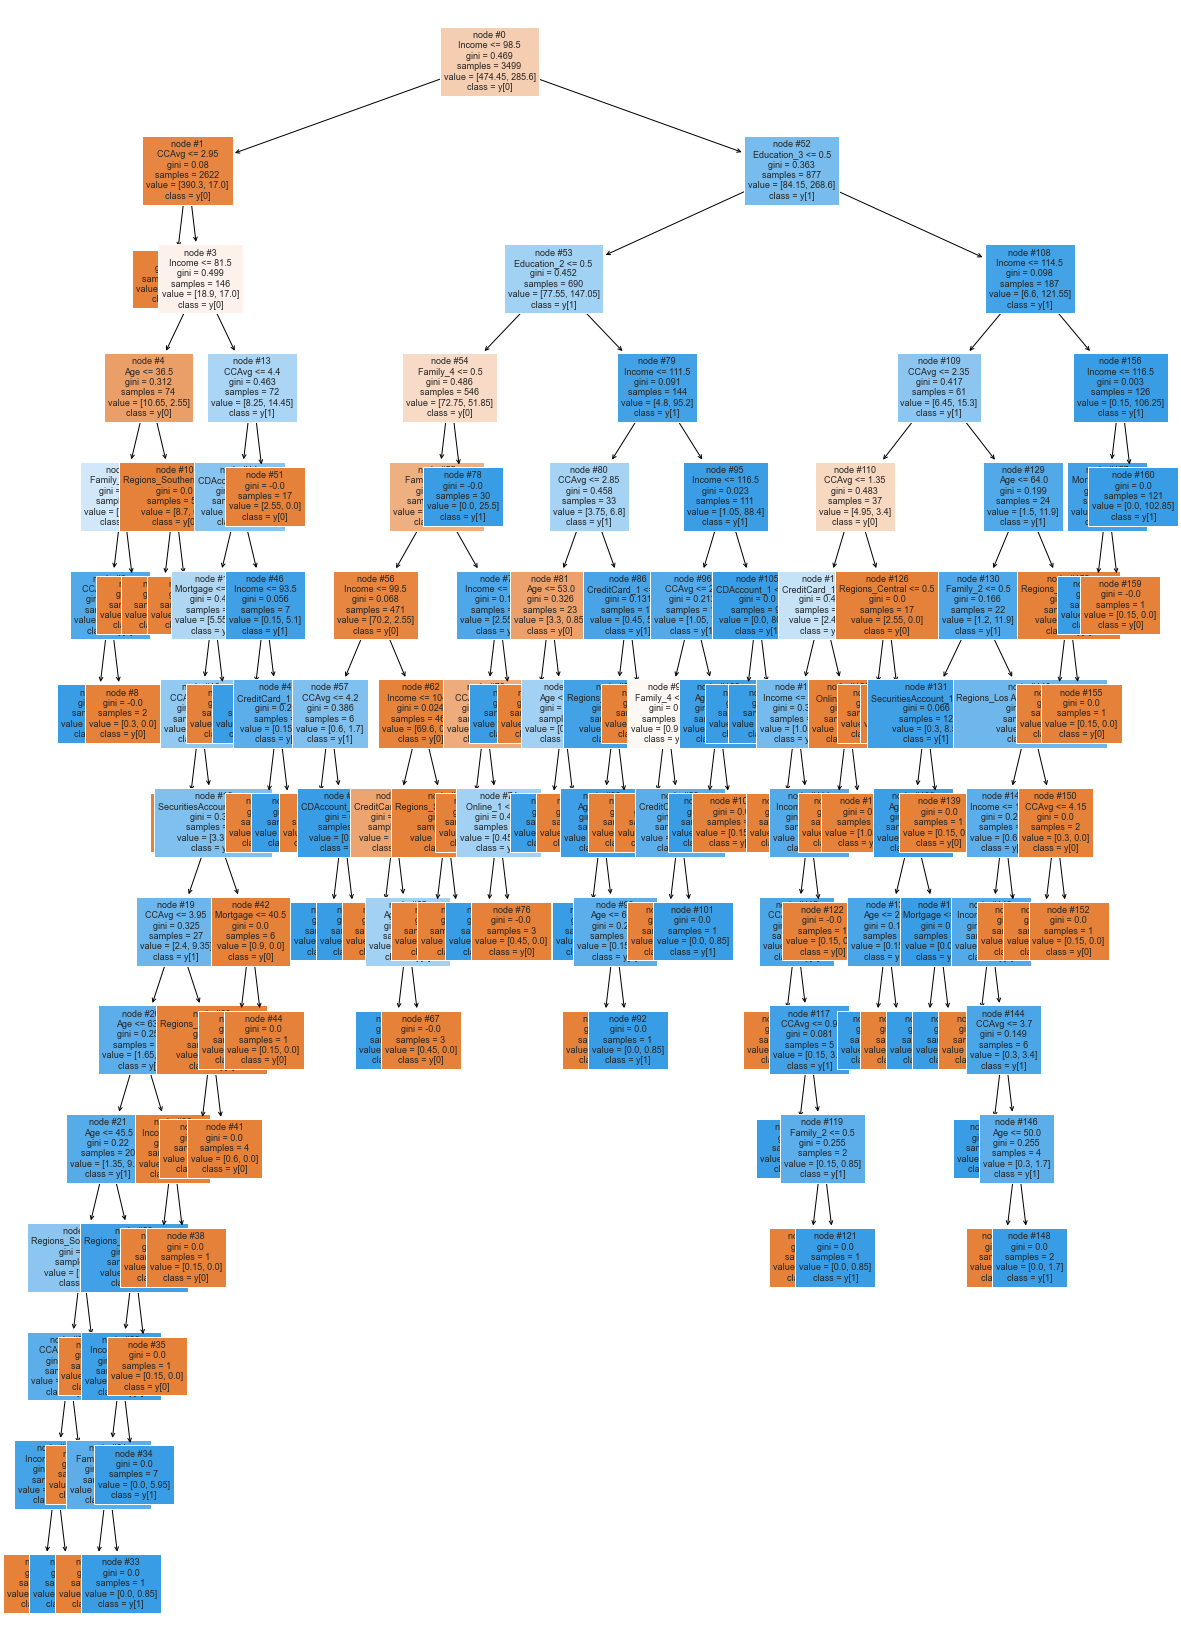

In [70]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV

plt.figure(figsize=(20,30))
out = tree.plot_tree(model, feature_names= feature_names, filled=True,
    fontsize=9, node_ids=True, class_names=True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)

plt.show()


In [71]:
print(tree.export_text(model, feature_names= feature_names, show_weights=True))

|--- Income <= 98.50
|   |--- CCAvg <= 2.95
|   |   |--- weights: [371.40, 0.00] class: 0
|   |--- CCAvg >  2.95
|   |   |--- Income <= 81.50
|   |   |   |--- Age <= 36.50
|   |   |   |   |--- Family_4 <= 0.50
|   |   |   |   |   |--- CCAvg <= 3.50
|   |   |   |   |   |   |--- weights: [0.00, 2.55] class: 1
|   |   |   |   |   |--- CCAvg >  3.50
|   |   |   |   |   |   |--- weights: [0.30, 0.00] class: 0
|   |   |   |   |--- Family_4 >  0.50
|   |   |   |   |   |--- weights: [1.65, 0.00] class: 0
|   |   |   |--- Age >  36.50
|   |   |   |   |--- Regions_Southern <= 0.50
|   |   |   |   |   |--- weights: [6.45, 0.00] class: 0
|   |   |   |   |--- Regions_Southern >  0.50
|   |   |   |   |   |--- weights: [2.25, 0.00] class: 0
|   |   |--- Income >  81.50
|   |   |   |--- CCAvg <= 4.40
|   |   |   |   |--- CDAccount_1 <= 0.50
|   |   |   |   |   |--- Mortgage <= 127.50
|   |   |   |   |   |   |--- CCAvg <= 3.05
|   |   |   |   |   |   |   |--- weights: [0.90, 0.00] class: 0
|   |   |   

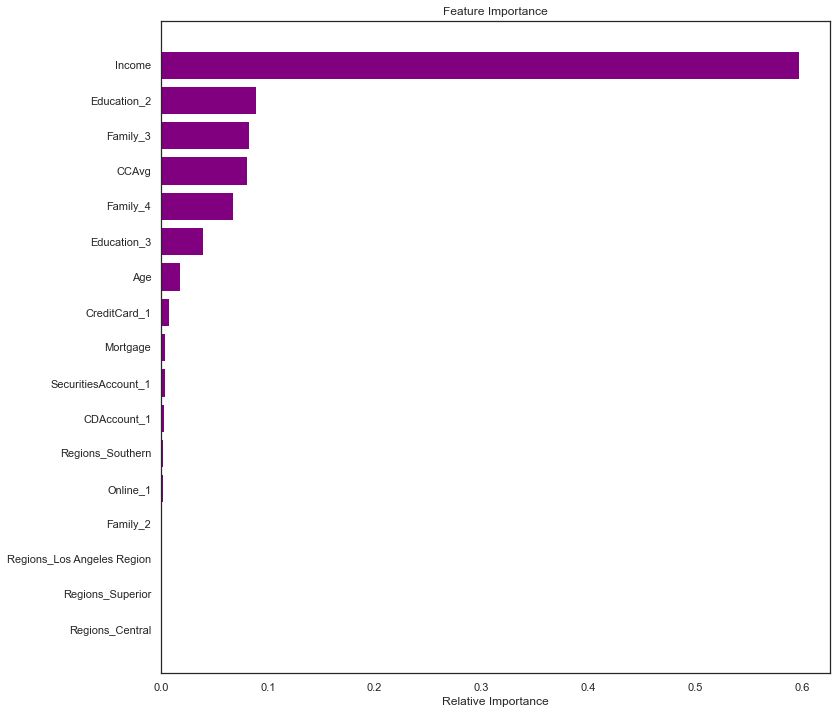

In [72]:
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color = 'purple', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [76]:
estimator = DecisionTreeClassifier(random_state=1)

parameters = {'max_depth':np.arange(1, 10),'min_samples_leaf': [1,2,5,7,10,15,20],'max_leaf_nodes': [5,10,15,20,25,30]}
                
acc_scorer = metrics.make_scorer(metrics.recall_score)

grid_obj = GridSearchCV(estimator, parameters, scoring=acc_scorer, cv=5)
grid_obj = grid_obj.fit(x_train_dt, y_train_dt)

estimator = grid_obj.best_estimator_
estimator

DecisionTreeClassifier(max_depth=9, max_leaf_nodes=30, min_samples_leaf=2,
                       random_state=1)

In [78]:
estimator.fit(x_train_dt, y_train_dt)
y_train_predict = estimator.predict(x_train_dt)
y_test_predict = estimator.predict(x_test_dt)

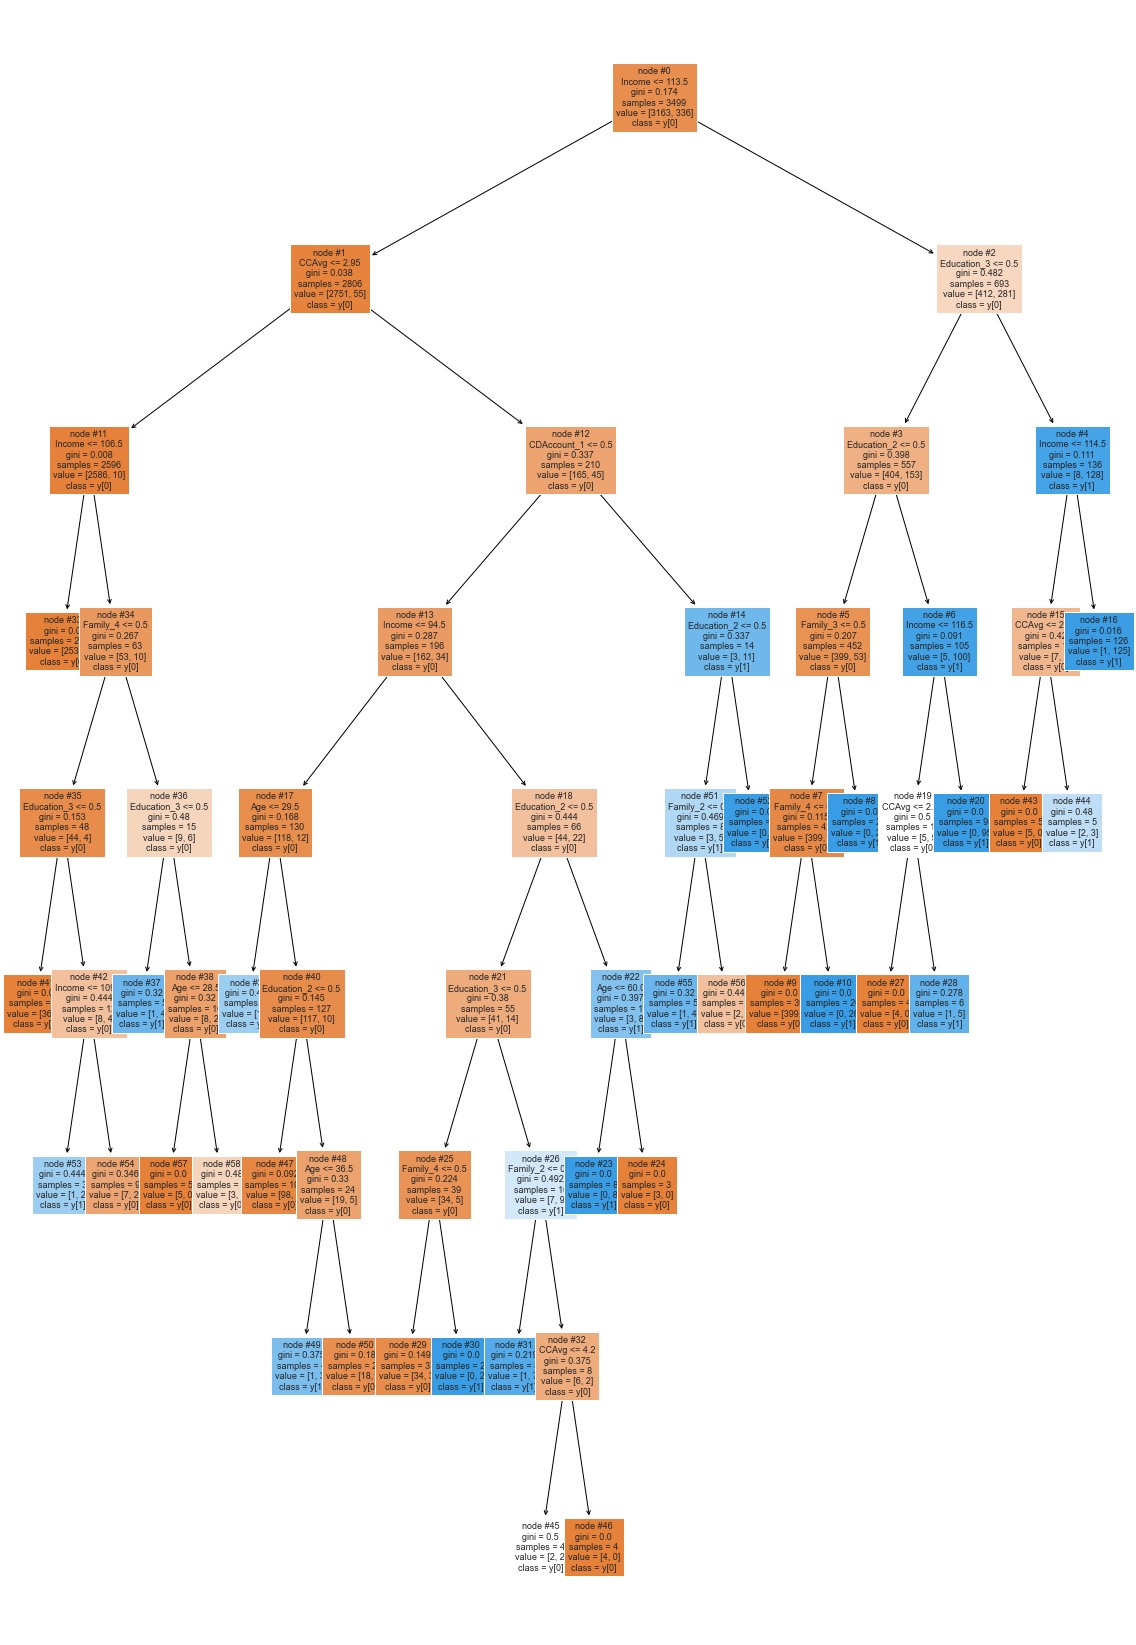

In [79]:
plt.figure(figsize=(20,30))
out = tree.plot_tree(estimator, feature_names= feature_names, filled=True,
    fontsize=9, node_ids=True, class_names=True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)

plt.show()